In [4]:
from basic_MDP.environment import Environment
import numpy as np 
import matplotlib.pyplot as plt
from basic_MDP.environment import Action
from basic_MDP.environment import State
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib as mpl

class Planner():

    def __init__(self, env):
        self.env = env
        self.log = []

    def initialize(self):
        self.env.reset()
        self.log = []

    def plan(self, gamma=0.9, threshold=0.0001):
        raise Exception("Planner have to implements plan method.")

    def transitions_at(self, state, action):
        transition_probs = self.env.transit_func(state, action)
        for next_state in transition_probs:
            prob = transition_probs[next_state]
            reward, _ = self.env.reward_func(next_state)
            yield prob, next_state, reward

    def dict_to_grid(self, state_reward_dict):
        grid = []
        for i in range(self.env.row_length):
            row = [0] * self.env.column_length
            grid.append(row)
        for s in state_reward_dict:
            grid[s.row][s.column] = state_reward_dict[s]

        return grid


class ValueIterationPlanner(Planner):

    def __init__(self, env):
        super().__init__(env)

    def plan(self, gamma=0.9, threshold=0.001):
        self.initialize()
        actions = self.env.actions
        V = {}
        for s in self.env.states:
            # Initialize each state's expected reward.
            V[s] = 0

        while True:
            delta = 0
            self.log.append(self.dict_to_grid(V))
            for s in V:
                if not self.env.can_action_at(s):
                    continue
                expected_rewards = []
                for a in actions:
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        r += prob * (reward + gamma * V[next_state])
                    expected_rewards.append(r)
                max_reward = max(expected_rewards)
                delta = max(delta, abs(max_reward - V[s]))
                V[s] = max_reward
                
            yield self.dict_to_grid(V)

            if delta < threshold:
                break

        #V_grid = self.dict_to_grid(V)
        #return V_grid


class PolicyIterationPlanner(Planner):

    def __init__(self, env):
        super().__init__(env)
        self.policy = {}

    def initialize(self):
        super().initialize()
        self.policy = {}
        actions = self.env.actions
        states = self.env.states
        for s in states:
            self.policy[s] = {}
            for a in actions:
                # Initialize policy.
                # At first, each action is taken uniformly.
                self.policy[s][a] = 1 / len(actions)

                
    def estimate_by_policy(self, gamma, threshold):
        V = {}
        for s in self.env.states:
            # Initialize each state's expected reward.
            V[s] = 0

        while True:
            delta = 0
            for s in V:
                expected_rewards = []
                for a in self.policy[s]:
                    action_prob = self.policy[s][a]
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        r += action_prob * prob * \
                             (reward + gamma * V[next_state])
                    expected_rewards.append(r)
                value = sum(expected_rewards)
                delta = max(delta, abs(value - V[s]))
                V[s] = value
            if delta < threshold:
                break

        return V

    def plan(self, gamma=0.9, threshold=0.001):
        self.initialize()
        states = self.env.states
        actions = self.env.actions

        def take_max_action(action_value_dict):
            return max(action_value_dict, key=action_value_dict.get)
        cnt = 1
        while True:
            cnt = cnt + 1
            update_stable = True
            # Estimate expected rewards under current policy.
            V = self.estimate_by_policy(gamma, threshold)
            self.log.append(self.dict_to_grid(V))
            
            for s in states:
                # Get an action following to the current policy.
                policy_action = take_max_action(self.policy[s])

                # Compare with other actions.
                action_rewards = {}
                for a in actions:
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        r += prob * (reward + gamma * V[next_state])
                    action_rewards[a] = r
                
                best_action = take_max_action(action_rewards)
                if policy_action != best_action:
                    update_stable = False

                # Update policy (set best_action prob=1, otherwise=0 (greedy))
                for a in self.policy[s]:
                    prob = 1 if a == best_action else 0
                    self.policy[s][a] = prob
                    
            
                    
            
            V_grid = self.dict_to_grid(V)
            yield V_grid, self.policy
            

            if update_stable:
                # If policy isn't updated, stop iteration
                break



In [6]:
grid = np.array([[0, 0, 0, 0, 0, 0], 
                 [0, 9, 1, 0, 0, 0], 
                 [0, 9, 9, -1, 0, 0], 
                 [0, -1, 0, 0, 0, 0], 
                 [0, 0, 0, 0, 0, 0]
                ])
env = Environment(grid)

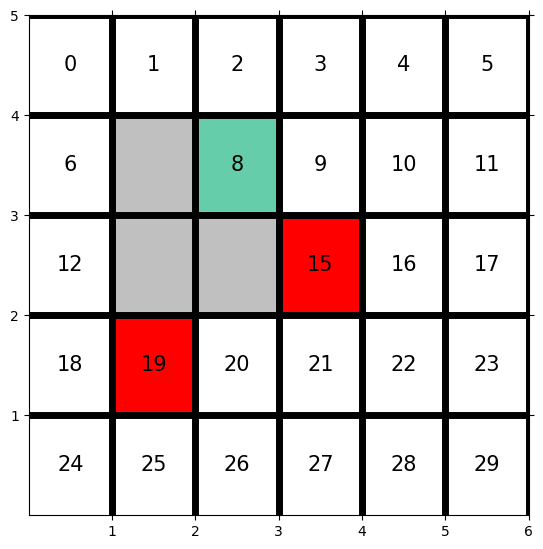

In [7]:
pol_iter_palanner = PolicyIterationPlanner(env)
pol_iter_palanner.initialize()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
num_font_size = 10
    # 数字
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):

        if(grid[i][j]==1):
            ax.add_patch(Rectangle((j, grid.shape[0]  - i - 1), 1, 1, fc='mediumaquamarine'))
                
        elif(grid[i][j]==9):
            ax.add_patch(Rectangle((j, grid.shape[0]  - i - 1), 1, 1, fc='silver'))
            continue

        elif(grid[i][j]==-1):
            ax.add_patch(Rectangle((j, grid.shape[0]  - i - 1), 1, 1, fc='red'))

        center_x = 0.5 + j
        center_y = grid.shape[0] - 0.5 - i

        plt.text(center_x, center_y, str(i*grid.shape[1] + j), size=15, ha='center', va='center', color = 'k')


    # 目盛りと枠の非表示
plt.tick_params(axis='both', which='both', bottom='off', top= 'off',labelbottom='off', right='off', left='off', labelleft='off')
    
plt.xlim(0, grid.shape[1])
plt.ylim(0, grid.shape[0])

plt.xticks(np.array(range(grid.shape[1])) + 1)
plt.yticks(np.array(range(grid.shape[0])) + 1)

plt.grid(color = 'k', linewidth = 5.0)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.savefig("grid_map.png")
plt.show()

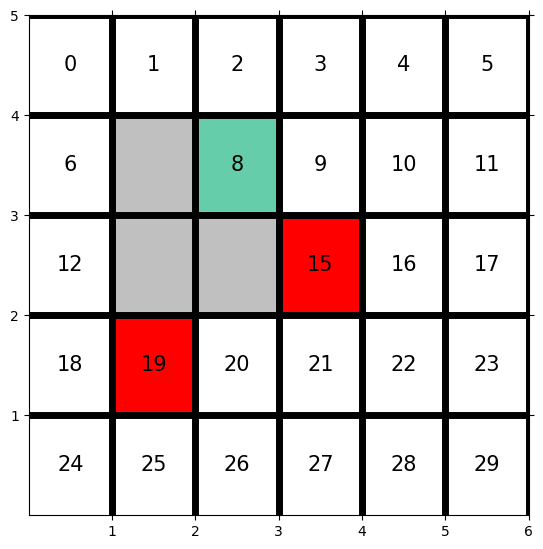

In [8]:
fig

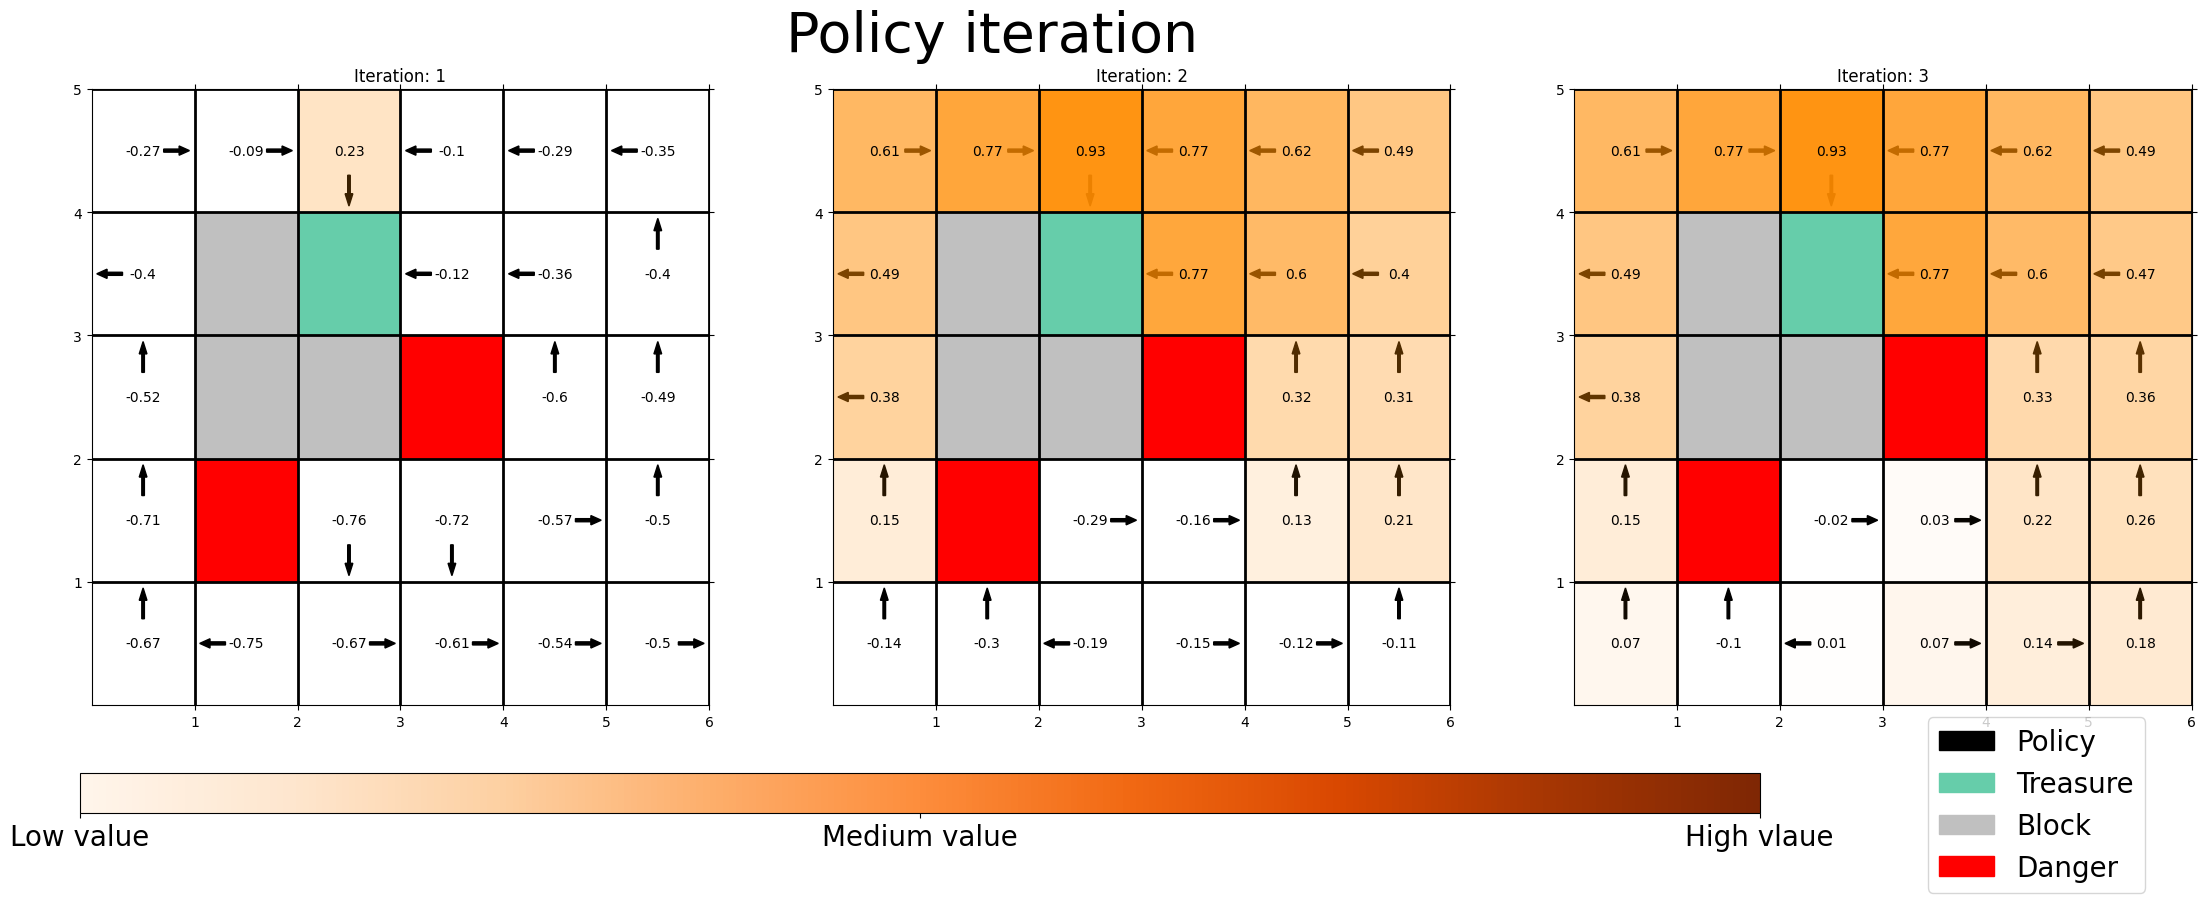

In [9]:
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(figsize=(24, 8))
fig.suptitle("Policy iteration", fontsize=40)

for cnt, (value, policy) in enumerate(pol_iter_palanner.plan()):
    state_list = list(policy.keys())
    #print(len(state_list))
    ax = fig.add_subplot(1, 3, cnt+1)
    #print(policy)
    num_font_size = 10
    # 数字
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
                
            if(grid[i][j]==1):
                ax.add_patch(Rectangle((j, grid.shape[0]  - i - 1), 1, 1, fc='mediumaquamarine'))
                continue
                
            elif(grid[i][j]==9):
                ax.add_patch(Rectangle((j, grid.shape[0]  - i - 1), 1, 1, fc='silver'))
                continue

            elif(grid[i][j]==-1):
                ax.add_patch(Rectangle((j, grid.shape[0]  - i - 1), 1, 1, fc='red'))
                continue
            action_value_dict = policy[state_list[i*grid.shape[0] + j]]
            center_x = 0.5 + j
            center_y = grid.shape[0] - 0.5 - i

            up = action_value_dict[Action.UP]
            down = action_value_dict[Action.DOWN]
            right = action_value_dict[Action.RIGHT]
            left = action_value_dict[Action.LEFT]
            plt.arrow(center_x, center_y + 0.2, 0.0, 0.15*up, width = 0.025*up, head_width=0.075*up, head_length=0.1*up, fc='k', ec='k')
            plt.arrow(center_x, center_y - 0.2, 0.0, -0.15*down, width = 0.025*down, head_width=0.075*down, head_length=0.1*down, fc='k', ec='k')
            plt.arrow(center_x + 0.2, center_y, 0.15*right, 0.0, width = 0.025*right, head_width=0.075*right, head_length=0.1*right, fc='k', ec='k')
            plt.arrow(center_x - 0.2, center_y, -0.15*left, 0.0, width = 0.025*left, head_width=0.075*left, head_length=0.1*left, fc='k', ec='k', label='Lokale Orientierung')
            ax.add_patch(Rectangle((j, grid.shape[0]  - i - 1), 1, 1,alpha=max(0, value[i][j]), fc='darkorange'))
            plt.text(center_x, center_y, str(round(value[i][j], 2)), size=10, ha='center', va='center', color = 'k')

    ## 円
    #circle, = plt.plot([0.5], [2.5], marker='o', color='#d3d3d3', markersize=40)
    # 目盛りと枠の非表示
    plt.tick_params(axis='both', which='both', bottom='off', top= 'off',
        labelbottom='off', right='off', left='off', labelleft='off')
    
    #ax.xlim(0, grid.shape[1])
    #ax.ylim(0, grid.shape[0])
    ax.axis([0, grid.shape[1], 0, grid.shape[0]])
    #ax.xticks(np.array(range(grid.shape[1])) + 1)
    #ax.yticks(np.array(range(grid.shape[0])) + 1)
    ax.set_xticks(np.array(range(grid.shape[1])) + 1)
    ax.set_yticks(np.array(range(grid.shape[0])) + 1)
    ax.grid(color = 'k', linewidth = 2.0)
    #ax.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.title.set_text('Iteration: ' + str(cnt + 1))
    #ax.box('off')
 

colors = ["white", "darkorange"]
#cmap = ListedColormap(colors, name="custom", N=2)
#cmap = LinearSegmentedColormap('original', colors)
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=matplotlib.cm.Oranges, norm=norm)
sm.set_array([])
plt.subplots_adjust(right=1)
cbar_ax = fig.add_axes([0.12, -0.025, 0.7, 0.05])
cbar = plt.colorbar(sm, 
             ticks=[0, 0.5, 1],
             orientation='horizontal'
            ,cax=cbar_ax,
            norm=norm)
cbar.ax.set_xticklabels(['Low value', 'Medium value', 'High vlaue'], fontsize=20)  # horizontal colorbar
grey_patch = mpatches.Patch(color='mediumaquamarine', label='Treasure')
orange_patch = mpatches.Patch(color='silver', label='Block')
purple_patch = mpatches.Patch(color='red', label='Danger')
arrow_patch = matplotlib.patches.Arrow(0, 0, 0, 0,color='black', label='Policy')

#arrow = matplotlib.patches.Arrow(color='black',label='My label')
loc = [1.1, -2]
plt.legend(handles=[arrow_patch, grey_patch, orange_patch, purple_patch], fontsize=20, loc=loc)
plt.savefig("policy_iter_heatmaps.png", bbox_inches='tight')
plt.show()

In [10]:
arrow_patch

In [12]:
from matplotlib.colors import ListedColormap

colors = ["white", "darkorange"]
#cmap = ListedColormap(colors, name="custom", N=2)
cmap = LinearSegmentedColormap(colors)
norm = matplotlib.colors.Normalize(vmin=5, vmax=10)

TypeError: LinearSegmentedColormap.__init__() missing 1 required positional argument: 'segmentdata'

In [ ]:
plt.get_cmap('Oranges')

In [8]:
grid.shape

(5, 6)

In [9]:
ppfeil

NameError: name 'ppfeil' is not defined

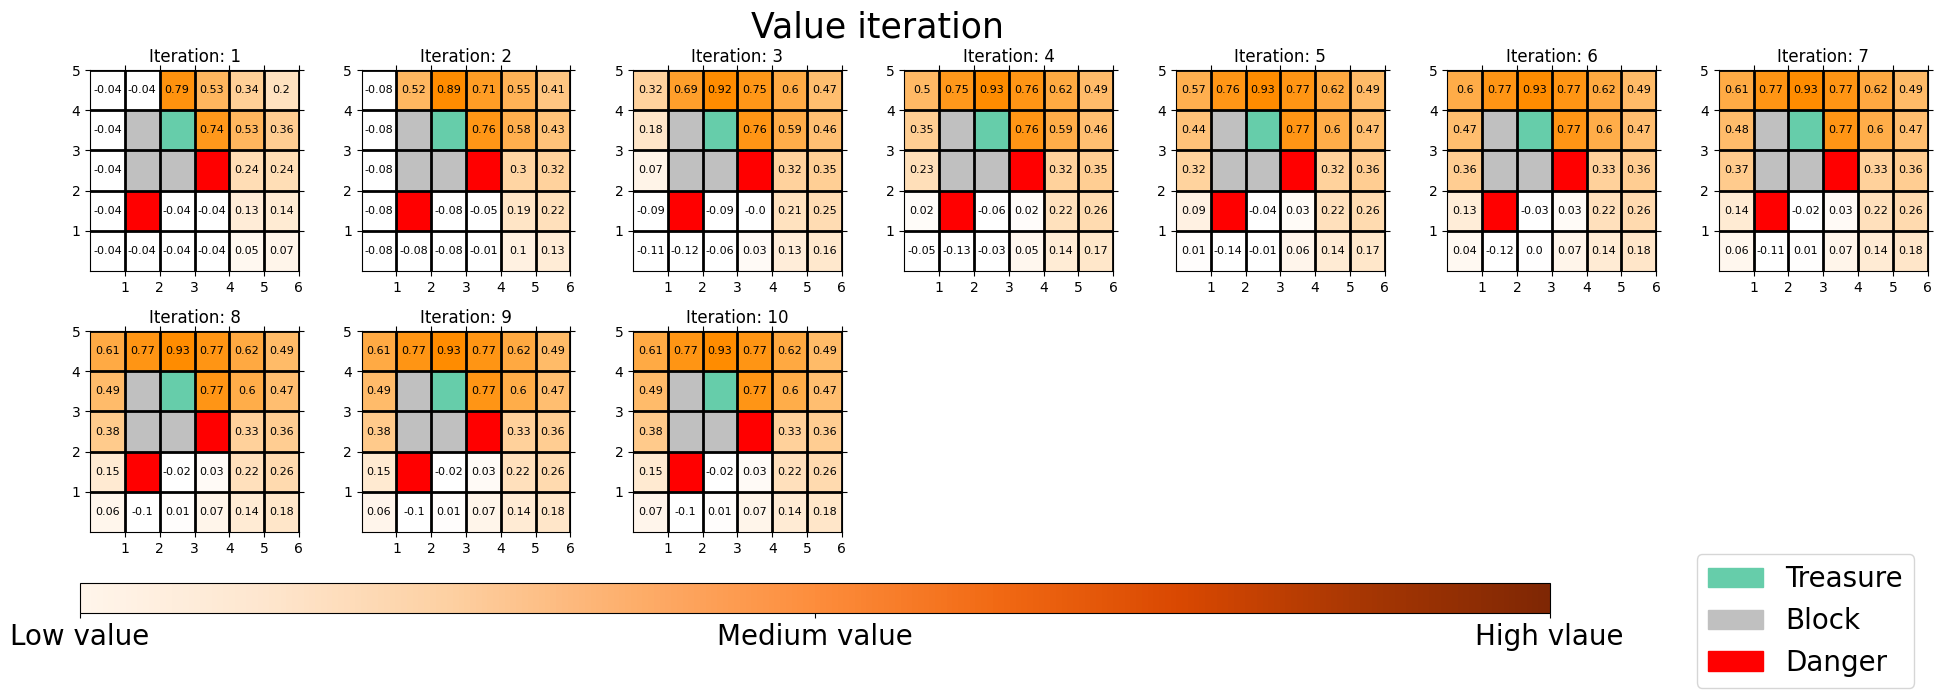

In [13]:
val_iter_palanner = ValueIterationPlanner(env)
val_iter_palanner.initialize()
fig = plt.figure(figsize=(21, 6))
fig.suptitle("Value iteration", fontsize=25)
#plt.subplots_adjust(left=0, right=1, bottom=0.0, top=1, wspace=1, hspace=1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for cnt, (value) in enumerate(val_iter_palanner.plan()):
    #print("Iteration: " + str(cnt + 1))
    state_list = list(policy.keys())
    ax = fig.add_subplot(2, 7,cnt+1)
    num_font_size = 10
    # 数字
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if(grid[i][j]==1):
                ax.add_patch(Rectangle((j, grid.shape[0]  - i - 1), 1, 1, fc='mediumaquamarine'))
                continue
                
            elif(grid[i][j]==9):
                ax.add_patch(Rectangle((j, grid.shape[0]  - i - 1), 1, 1, fc='silver'))
                continue

            elif(grid[i][j]==-1):
                ax.add_patch(Rectangle((j, grid.shape[0]  - i - 1), 1, 1, fc='red'))
                continue

            action_value_dict = policy[state_list[i*grid.shape[0] + j]]
            center_x = 0.5 + j
            center_y = grid.shape[0] - 0.5 - i
            ax.add_patch(Rectangle((j, grid.shape[0]  - i - 1), 1, 1,alpha=min(1, max(0, value[i][j])*1.2), fc='darkorange'))
            ax.text(center_x, center_y, str(round(value[i][j], 2)), size=8, ha='center', va='center', color = 'k')


    # 目盛りと枠の非表示
    ax.tick_params(axis='both', which='both', bottom='off', top= 'off',
        labelbottom='off', right='off', left='off', labelleft='off')
    
    #ax.xlim(0, grid.shape[1])
    #ax.ylim(0, grid.shape[0])
    ax.axis([0, grid.shape[1], 0, grid.shape[0]])
    #ax.xticks(np.array(range(grid.shape[1])) + 1)
    #ax.yticks(np.array(range(grid.shape[0])) + 1)
    ax.set_xticks(np.array(range(grid.shape[1])) + 1)
    ax.set_yticks(np.array(range(grid.shape[0])) + 1)
    ax.grid(color = 'k', linewidth = 2.0)
    #ax.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.title.set_text('Iteration: ' + str(cnt + 1))
    #ax.box('off')
    
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=matplotlib.cm.Oranges, norm=norm)
sm.set_array([])
plt.subplots_adjust(right=1)
cbar_ax = fig.add_axes([0.12, -0.025, 0.7, 0.05])
cbar = plt.colorbar(sm, 
             ticks=[0, 0.5, 1],
             orientation='horizontal'
            ,cax=cbar_ax,
            norm=norm)
cbar.ax.set_xticklabels(['Low value', 'Medium value', 'High vlaue'], fontsize=20)  # horizontal colorbar
grey_patch = mpatches.Patch(color='mediumaquamarine', label='Treasure')
orange_patch = mpatches.Patch(color='silver', label='Block')
purple_patch = mpatches.Patch(color='red', label='Danger')

loc = [1.1, -2.5]
plt.legend(handles=[grey_patch, orange_patch, purple_patch], fontsize=20, loc=loc)
plt.savefig("value_iter_heatmaps.png", bbox_inches='tight')
plt.show()